*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# To Boldly Go



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/track.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [226]:
from os.path import basename, exists


def download(url, filename=None):
    if filename is None:
        filename = basename(url)
        
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, underride

## Image Processing

If you have worked with computer graphics, you might know that there are two common ways to represent images, bitmaps and vectors.
A bitmap is like an array where each element represents the color of a pixel.
A vector represents a coordinate in space.

If you have an image in vector format, you can create a bitmap by rendering the vectors.
If you have an image in bitmap format, it is not as easy to generate vectors, but there are image processing algorithms that make it possible.

As an example, we'll start with an image of the starship *Enterprise* from the original series of Star Trek.
The model used in the television show is now in the  Smithsonian National Air and Space Museum.
The following cell downloads a photo of the model, originally from the [museum's web site](https://airandspace.si.edu/collection-media/NASM-A19740668000-NASM2016-02687-000001).

In [229]:
# TODO: download from repo
# download("")

https://airandspace.si.edu/collection-media/NASM-A19740668000-NASM2016-02354-000005
https://airandspace.si.edu/collection-media/NASM-A19740668000-NASM2016-02687-000001

https://airandspace.si.edu/collection-objects/model-starship-enterprise-television-show-star-trek/nasm_A19740668000

In [232]:
filename = "pngaaa.com-4115597.png"
filename = "1701-gus-top.jpg"
filename = "scan0004a.jpg"
filename = "NASM-A19740668000-NASM2016-02687-000001-scaled.jpg"

scikit-image provides functions we'll use to process the image, starting with `io.imread`, which reads the image and returns a NumPy array.

In [233]:
from skimage import io, color, filters, measure

image = io.imread(filename)
image.shape

(287, 750, 3)

The image in 287 pixels by 750 pixels, and each pixel is represented by three numbers, levels of red, green, and blue (RGB).

We'll use `color.rgb2gray` to convert the image from RGB to grayscale.

In [280]:
gray = color.rgb2gray(image)
gray.shape

(287, 750)

The result is a NumPy array with one number per pixel, in the range from 0, which represented black, to 1, which represents white.

In [288]:
# gray[170:175, 370:375]

We can use the Matplotlib function `imshow` to display the image.
The color map `gray_y` reverses the scale, showing the image in negative -- so it appears on a white background.

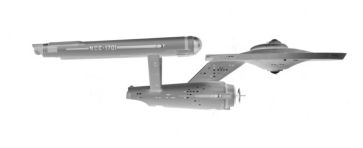

In [235]:
plt.imshow(gray, cmap="gray_r")
plt.axis("off");

scikit-image provides `find_contours`, which takes an image and finds a sequence of line segments that trace the boundary between light and dark regions.
The `level` parameter in the threshold that determines how dark is considered dark.

In [306]:
contours = measure.find_contours(gray, level=0.05)
len(contours)

10

The result is a list of contours -- each of them is a NumPy array with one row for each point that makes up the contour.

In [620]:
contour = contours[0]
contour.shape

(2493, 2)

In this example, there are 2492 rows, one for each point, and two columns, containing the row and column of a pixel in the image.

If we transpose the array, the result has two rows, containing the `y` and `x` coordinates of the pixels, which we'll separate into two arrays.

In [621]:
ys, xs = np.transpose(contour)

It will be convenient to reduce the number of points in the contour.
For that, we'll use a `LineString` object and its `simplify` method.

In [622]:
from shapely.geometry import LineString

line = LineString(np.transpose([xs, ys]))
simplified = line.simplify(tolerance=2.0)

The results is a `LineString` object that approximates the contour with fewer points.
The `tolerance` argument determines how close the approximation is.

We can select `coords` from the result and convert to a NumPy array.

In [655]:
coords = np.array(simplified.coords)
coords.shape

(67, 2)

The result has only 67 points, which is much more manageable.
We'll use the following function to plot contours.

In [658]:
def plot_contour(contour, **options):
    underride(options, color="C0", alpha=0.5)
    xs, ys = np.transpose(contour)
    plt.plot(xs, ys, **options)
    decorate(aspect='equal')

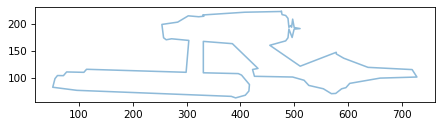

In [659]:
plot_contour(coords)

The result looks good, but you might notice that it is upside down.
That's because `find_contour` uses graphics coordinates, where the `y` axis points down, and Matplotlib uses Cartesian coordinates, where the `y` axis points up.
In the next section, we'll flip it.

## Transformations

To flip the `y` coordinates and leave the `x` coordinates alone, we can multiply `coords` by the list `[1, -1]`.

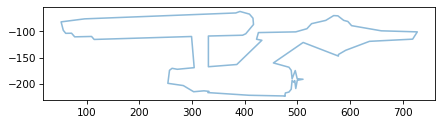

In [660]:
flipped = coords * [1, -1]
plot_contour(flipped)

Let's unpack how that works.
Because `coords` is an array, the list gets converted to an array with shape `(2,)` -- that's a tuple with a single element.

In [661]:
array = np.array([1, -1])
array.shape

(2,)

The shape of `coords` is `(67, 2)`, which we can think of as 67 rows and 2 columns.

In [662]:
coords.shape

(67, 2)

Because the last element of the shapes is the same, the array can be broadcast, which we can think of as adding an additional dimension.
We can do the broadcast explicitly like this.

In [663]:
broadcast = array[None, :]
broadcast.shape

(1, 2)

`None` represents the new dimension, and `:` selects all elements of the existing dimension.
The result has shape `(1, 2)`, which we can think of as one row and two columns.
Then when we multiply by `coords`, the row gets copied 67 times.

In [664]:
flipped = coords * broadcast
flipped.shape

(67, 2)

So the result has the same shape as `coords`.

We can use a similar pattern to shift the coordinates so the center of the ship is at the origin.
First we'll compute the mean of the coordinates along `axis=0`.
To remember what that means, think of specifying which axis should be removed.
In this case, removing the first axis leaves only the second, with length `2`.


In [665]:
mean = flipped.mean(axis=0)
mean

array([ 413.92312692, -141.35716452])

So the result is the mean of the rows.
If we subtract it from `flipped`, it gets broadcast and subtracted from each row -- so each coordinate gets shifted left by about 413 pixels and up by about 141.

In [666]:
shifted = flipped - mean

The result looks the same, but now it's centered at the origin.

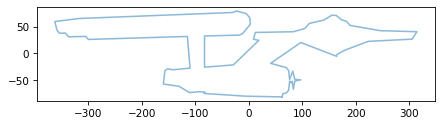

In [667]:
plot_contour(shifted)

While we're at it, let's scale the coordinates down so the largest coordinate is about `1`.
For that we don't need an array -- we can divide all of the elements by a scalar.

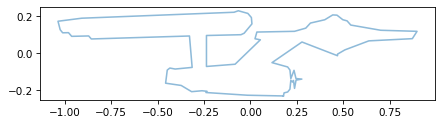

In [669]:
scaled = shifted / 350
plot_contour(scaled)

The operations we performed in this section -- flip, shift, and scale -- are examples of transformations.
We performed them using array operations, but they can also be expressed using vector and matrix operations, as we'll see soon.

But first let's consider two ways to represent vectors.

## Row Vectors and Column Vectors

In the examples so far, we've used NumPy arrays with one row for each vector, and two columns.
For example, the simplified contour of the ship has 67 rows, one for each point on the contour.

In [670]:
coords.shape

(67, 2)

Vectors in this form are called **row vectors**.
This form works well with number because we can iterate through the vectors by iterating through the rows of the array.
And we can shift and scale the vectors using array operators like addition and multiplication. 

An alternative is to transpose the array so it has two rows and one column per vector.

In [671]:
transposed = coords.T
transposed.shape

(2, 67)

Vectors in this form are called **column vectors**.
This format is convenient if we want to extract the coordinates of the points as separate arrays, as we do in `plot_contour`.

In [672]:
xs, ys = transposed
xs.shape

(67,)

This format is also useful when we perform linear algebra operations like matrix multiplication.
As we'll see in the next few sections, most linear algebra operations are defined in terms of column vectors, and don't work with row vectors.



In [673]:
ship = scaled
ship.shape

(67, 2)

Now let's do some linear algebra.

## Contours and Vectors

So far we've been thinking of `ship` as a sequence of coordinate pairs.
To plot it, we can separate the `x` and `y` coordinates, and Matplotlib to connect the dots.

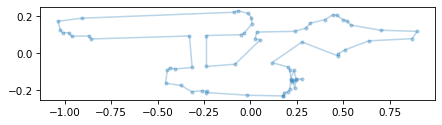

In [674]:
xs, ys = ship.T
plt.plot(xs, ys, ".-", alpha=0.3)
decorate(aspect='equal')

But we can also think of `ship` as a collection of vectors with their tails at the origin and their heads on the contour.
We can use `plot_vectors` to see what that looks like.

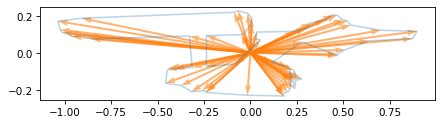

In [675]:
from utils import plot_vectors

plt.plot(xs, ys, "-", alpha=0.3)
plot_vectors(ship, width=0.005, color="C1")
decorate(aspect='equal')

Now to connect the dots, we can use vector subtraction to compute the difference between each vector and the next.

In [676]:
rolled = np.roll(ship, shift=1, axis=0)
diffs = rolled - ship

To see how that works, let's consider the first three rows of `ship`.

In [677]:
ship[:3]

array([[ 0.17736249, -0.23266345],
       [-0.01692322, -0.22877882],
       [-0.23978036, -0.21419931]])

And the first three rows of `rolled`.

In [678]:
rolled[:3]

array([[ 0.17736249, -0.23266345],
       [ 0.17736249, -0.23266345],
       [-0.01692322, -0.22877882]])

`rolled` contains the coordinate pairs from `ship`, with each one shifted down one position, and the last rolled around to become the first.
When we subtract, the result contains vectors that point from each point on the contour to the next -- which we can plot like this.

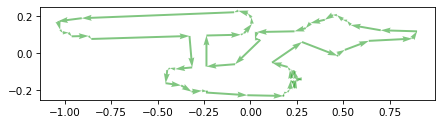

In [679]:
plot_vectors(diffs, ship, width=0.005, color="C2")
decorate(aspect='equal')

If we think of coordinates as vectors, we can think of transformations like shifting and scaling as vector operations -- and that turns out to be useful.
Let's start with scaling.


## Scale

In this section we'll represent scaling as a vector-matrix product.
To show what that means, we'll use SymPy to make a symbolic vector.

In [680]:
from sympy import symbols, Matrix

def make_vector(x, y):
    return Matrix([[x], [y]])

To represent a vector, we'll use a SymPy `Matrix` with two rows and one column. 

In [681]:
x, y = symbols('x y')
v = make_vector(x, y)
v

Matrix([
[x],
[y]])

To be precise, this is a **column vector**.

Now we'll use the following function to make a scale matrix.
The parameters `sx` and `sy` specify the scale factor in the `x` and `y` directions.

In [682]:
def scale_matrix(sx, sy):
    return Matrix([[sx, 0], [0, sy]])

To show what that looks like, I'll create a scale matrix with symbolic values of `sx` and `sy`.

In [683]:
sx, sy = symbols('s_x s_y')

S = scale_matrix(sx, sy)
S

Matrix([
[s_x,   0],
[  0, s_y]])

Now we can multiply `S` and `v` using the matrix multiplication operator, `@`.

In [684]:
S @ v

Matrix([
[s_x*x],
[s_y*y]])

The result is a column vector where the `x` coordinate has been multiplied by `sx` and the `y` coordinate has been multiplied by `sy`.

To make the example more concrete, I'll make a vector that squishes the `x` coordinate by 25% and stretches the `y` coordinate by 50%.

In [685]:
S = scale_matrix(0.75, 1.5)
S

Matrix([
[0.75,   0],
[   0, 1.5]])

Now let's apply this transformation to the contour of the ship.
Unfortunately, using the scale matrix in this way only works with column vectors, and the contour is a collection of row vectors.
We can solve this problem by transposing the contour before applying the transformation.

In [686]:
scaled = S @ ship.T
scaled.shape

(2, 67)

The result is a collection of column vectors, so we have to transpose it before plotting.

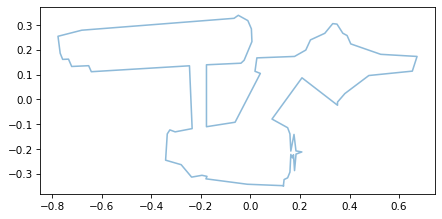

In [688]:
plot_contour(scaled.T)

As expected, it is compressed in the `x` direction and stretched in the `y` direction.



Now let's consider two other transformations, shear and rotation.

## Shear

Shearing is a transformation it will be easier to show than describe.
We'll start by making a shear matrix that takes two parameters, the amount of shear in the `x` and `y` directions.

In [689]:
def shear_matrix(kx, ky):
    return Matrix([[1, kx], [ky, 1]])

Here's what it looks like with symbolic elements.

In [690]:
kx, ky = symbols('k_x, k_y')

K = shear_matrix(kx, ky)
K

Matrix([
[  1, k_x],
[k_y,   1]])

And here's the effect it has if we multiply by a vector.

In [691]:
K @ v

Matrix([
[k_x*y + x],
[k_y*x + y]])

The shear matrix adds some fraction of `y` to the `x` coordinate and some fraction of `x` to the `y` coordinate.
But it's probably still not clear what that means.

Let's see an example, a horizontal shear with `kx = 0.5`.

In [692]:
K = shear_matrix(0.5, 0)
K

Matrix([
[1, 0.5],
[0,   1]])

Here's the effect on a symbolic vector.

In [693]:
K @ v

Matrix([
[x + 0.5*y],
[        y]])

Every point gets shifted to the right by half of its `y` coordinate.
Let's see what that looks like if we apply it to the ship.

In [694]:
sheared = K @ ship.T

It will be easier to see the result if we make a bounding box.

In [695]:
def make_bbox(contour):
    xmin, ymin = contour.min(axis=0)
    xmax, ymax = contour.max(axis=0)

    return np.array([
        [xmin, ymin],
        [xmax, ymin],
        [xmax, ymax],
        [xmin, ymax],
        [xmin, ymin],
    ])

And apply the same transform to the bounding box.

In [696]:
bbox = make_bbox(ship)
bbox_sheared = K @ bbox.T

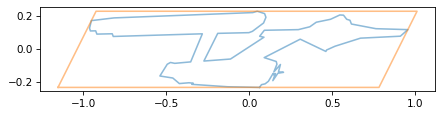

In [698]:
plot_contour(sheared.T)
plot_contour(bbox_sheared.T, color='C1')

If we think of the bounding box as a stack of sheets of paper, a horizontal shear has the effect of shifting the sheets to the right in proportion to their height.

As an exercise at the end of the chapter, you'll have a chance to experiment with a vertical shear and the composition of a horizontal and vertical shear.

## Rotation

In addition to scaling and shearing, we can also express rotation as matrix multiplication.
We'll start by defining a unit vector, which we'll use to specify the angle of rotation.

In [720]:
from utils import normalize

v_hat = normalize([1, 0.5])

Along with `v_hat`, we'll also need a perpendicular vector we'll call `v_perp`.

In [721]:
x, y = v_hat
v_perp = [-y, x]

Here's what those vectors look like, along with unit vectors that represent the `x` and `y` axes.

In [724]:
i_hat = np.array([1, 0])
j_hat = np.array([0, 1])

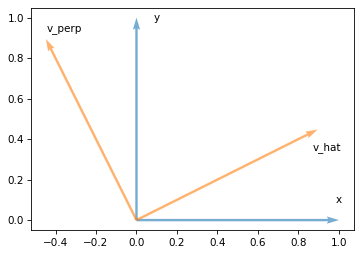

In [725]:
plot_vectors([i_hat, j_hat], 
             labels=['x', 'y'], label_pos=[11, 1])
plot_vectors([v_hat, v_perp], color='C1', 
             labels=['v_hat', 'v_perp'], label_pos=[1, 1])
decorate(aspect='equal')

We can think of rotation as a transformation that transforms the `x` axis to `v_hat` and the `y` axis to `v_perp`.
So one way to specify a rotation is by building a matrix with `v_hat` and `v_perp` as columns -- which we can do most conveniently by stacking them as rows and then transposing.

In [726]:
def rotation_matrix(v_hat):
    x, y = v_hat
    v_perp = [-y, x]
    return Matrix([v_hat, v_perp]).T

Here and example based on `v_hat`.

In [727]:
R = rotation_matrix(v_hat)
R

Matrix([
[0.894427190999916, -0.447213595499958],
[0.447213595499958,  0.894427190999916]])

Now if we multiply by the `x` axis, it selects the first column of the matrix, which is `v_hat`.

In [729]:
R @ i_hat.T

array([0.894427190999916, 0.447213595499958], dtype=object)

And if we multiply by the `y` axis, it selects the second column of the matrix, which is `v_perp`.

In [730]:
R @ j_hat.T

array([-0.447213595499958, 0.894427190999916], dtype=object)

Finally, if we multiply by any other vector, the effect is to rotate the vector by the same amount we rotated the axes.
As an example, we'll rotate the vectors in the contour of the ship.

In [731]:
rotated = R @ ship.T

The effect is to rotate the ship around the origin.

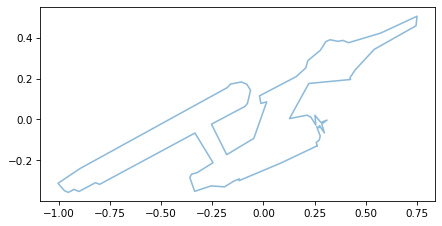

In [733]:
plot_contour(rotated.T)

At this point we've created matrices that scale, shear, and rotate vectors.
Now let's put them together!

## Composition

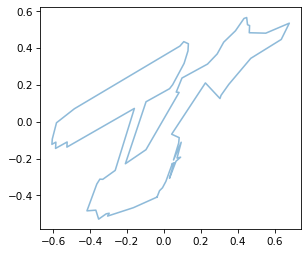

In [549]:
transformed = R @ H @ S @ ship.T
plot_contour(transformed)

In [554]:
T = R @ H @ S
transformed = T @ ship.T

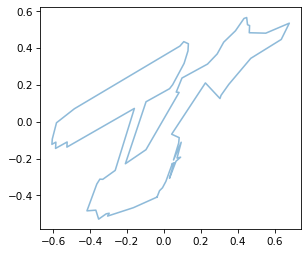

In [555]:
plot_contour(transformed)

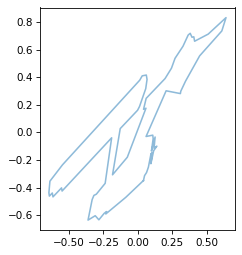

In [559]:
T2 = S @ R @ H
plot_contour(T2 @ ship.T)

## Homogeneity!

In [567]:
def translation_matrix(dx, dy):
    return Matrix([[1, 0, dx],
                   [0, 1, dy],
                   [0, 0, 1]])

In [568]:
T = translation_matrix(1, 0.5)

In [569]:
v3 = Matrix([[x], [y], [1]])
v3

Matrix([
[x],
[y],
[1]])

In [566]:
T @ v3

Matrix([
[  x + 1],
[y + 0.5],
[      0]])

In [604]:
ship.shape

(67, 2)

In [607]:
def augment_contour(contour):
    rows, cols = contour.shape
    ones = np.ones((rows, 1))
    return np.hstack([contour, ones])

In [608]:
ship3 = augment_contour(ship)
ship3.shape

(67, 3)

In [609]:
translated = T @ ship3.T

In [611]:
def diminish_contour(contour):
    return contour[:2, :]

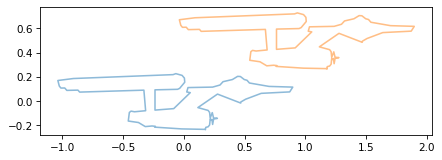

In [613]:
plot_contour(ship.T)
plot_contour(diminish_contour(translated), color='C1')

## Orbit

In [615]:
n = 100
thetas = np.linspace(0, 2 * np.pi, n)
xs = np.cos(thetas)
ys = np.sin(thetas)
ones = np.ones(n)
circle = np.transpose([xs, ys, ones])
circle.shape

(100, 3)

In [594]:
a, b = 10, 7

In [595]:
c = np.sqrt(a**2 - b**2)
c

np.float64(7.14142842854285)

In [596]:
e = c / a
e

np.float64(0.7141428428542851)

In [603]:
c_vec = make_vector(c, 0)
c_vec

Matrix([
[7.14142842854285],
[               0]])

In [602]:
S = scale_matrix(a, b)
orbit = S @ circle.T + c_vec

ShapeError: Matrix size mismatch: (2, 100) + (2, 1).

In [599]:
r_vec = orbit[10]
r_vec

array([15.1941310038534, 4.15035550338248], dtype=object)

In [145]:
from utils import norm

def vis_viva(r_vec, a, mu=1):
    r = norm(r_vec)
    v = np.sqrt(mu * (2 / r - 1 / a))
    return v
    
v = vis_viva(r_vec, a)
v

np.float64(0.16424932050106758)

In [146]:
def vector_perp(v):
    x, y = v
    return np.array([-y, x])

In [147]:
def ellipse_tangent(r_c, a, b):
    x, y = r_c
    n_vec = np.array([x / a**2, y / b**2])
    n_hat = normalize(n_vec)
    return n_hat, vector_perp(n_hat)

In [148]:
n_hat, v_hat = ellipse_tangent(r_vec-c_vec, a, b)

In [149]:
v_vec = v * v_hat
v_vec

array([-0.11903788,  0.11317165])

ValueError: too many values to unpack (expected 2)

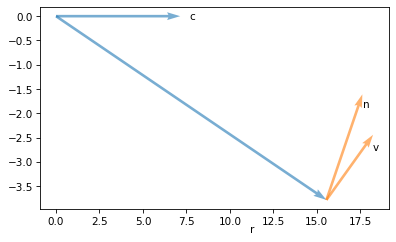

In [592]:
plot_vector(r_vec, label='r', label_pos=2)
plot_vector(c_vec, label='c')
plot_vector(n_hat, r_vec, scale=3, label='n', label_pos=1, color='C1')
plot_vector(v_hat, r_vec, scale=3, label='v', label_pos=1, color='C1')
plot_contour(orbit, alpha=0.1)

In [151]:
def compute_transform(r_vec, a, b, sol=1):
    v = vis_viva(r_vec, a)
    n_hat, v_hat = ellipse_tangent(r_vec-c_vec, a, b) 
    
    R = rotation_matrix(v_hat)
    
    sx = np.sqrt(1 - v / sol)
    S = scale_matrix(sx, 1)
    
    F = scale_matrix(1, -1)
    return F @ S @ R

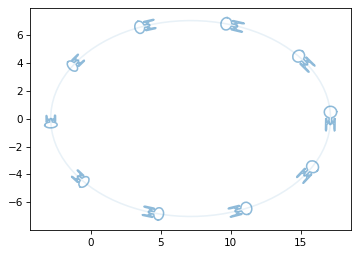

In [152]:
for r_vec in orbit[::10]:
    T = compute_transform(r_vec, a, b)
    transformed = ship @ T + r_vec
    plot_contour(transformed)
    
plot_contour(orbit, alpha=0.1)

In [153]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
[ship_line] = plt.plot([], [], alpha=0.5, color="C0")
[orbit_line] = plt.plot(*orbit.T, alpha=0.1, color="C0")
ax.set_aspect('equal')

def animate_frame(frame_num):    
    r_vec = orbit[frame_num]
    T = compute_transform(r_vec, a, b)
    transformed = ship @ T + r_vec
    ship_line.set_data(*transformed.T)

anim = animation.FuncAnimation(fig, 
                               animate_frame, 
                               frames=len(orbit), 
                               interval=50,
                               repeat=True)

plt.close(fig)
HTML(anim.to_jshtml())

In [154]:
# HTML(anim.to_html5_video())

In [155]:
from IPython.display import clear_output

def animate(iterator, interval=0.001):
    """Run a frame generator that yields once per update."""
    plt.ion()
    plt.figure()
    try:
        for _ in iterator:
            plt.pause(interval)
            clear_output(wait=True)
        plt.show()
    except KeyboardInterrupt:
        pass
    finally:
        plt.ioff()

def animation_generator(orbit, ship, a, b): 
    for r_vec in orbit:
        T = compute_transform(r_vec, a, b)
        transformed = ship @ T + r_vec

        plot_contour(orbit, alpha=0.1)
        plot_contour(transformed)
        plt.xlim(-4, 19)
        plt.ylim(-8, 8)
        yield

iterator = animation_generator(orbit, ship, a, b)
# animate(iterator, interval=0.001)

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)